<h1>Отчет за 25.02.21</h1>

<p>Подключим необходимые для корректной работы библиотеки.</p>

In [111]:
from math import *
from scipy import special
import numpy as np
import cmath
import time
import pandas as pd
import plotly.graph_objects as go
from IPython.display import display, Image, SVG, Math, YouTubeVideo
import matplotlib.pyplot as plt
import openpyxl

<p>Определим функцию $sinc(x)$.</p>

In [112]:
def sinc(x):
    '''
    Compute the sinc-function: sin(x) / x
    '''
    try:  
        return sin(x) / x
    except ZeroDivisionError:
        return 1.

<h2>Поставим теперь задачу:</h2>
<p>Требуется реализовать программу, результатом работы которой мы бы получили два набора функций, один из которых представлял бы из себя набор сферических функции Бесселя от нулевого до порядка, который передается в программу в виде параметра (назовем его $N_{max}$), а другой - массив сферических функций Неймана тех же порядков.</p>
<p>Сферические функции Бесселя и Неймана и их производные могут быть рассчитаны по известным рекуррентным соотношениям:
</p>

$$s_n(\zeta) = \frac{2n - 1}{\zeta}s_{n-1}(\zeta)-s_{n-2}(\zeta) \tag{A1}$$

$$s_n^{'}(\zeta) = s_{n-1}(\zeta)-\frac{n + 1}{\zeta}s_{n}(\zeta) \tag{A2}$$

<p>где $s_n(\zeta)$ - условное обозначение одного из видов сферических функций, $\zeta$ - аргумент соответствующей функции.</p>
<p>Рекуррентная процедура $(А1)$ использует известные выражения для функций 0-го и 1-го порядков:</p>
$$j_0(\zeta)=\frac{sin\zeta}{\zeta},$$

$$j_1(\zeta)=-j_0^{'}(\zeta)=-\frac{cos\zeta}{\zeta}+\frac{sin\zeta}{\zeta^2},$$

$$y_0(\zeta)=-\frac{cos\zeta}{\zeta},$$

$$y_1(\zeta)=-y_0^{'}(\zeta)=-\frac{sin\zeta}{\zeta}-\frac{cos\zeta}{\zeta^2}.$$

<p>Но есть маленький нюанс. Процедура $(А1)$ является устойчивой для функций Неймана любых порядков и функций Бесселя порядков $n \leq \zeta$. Функции Бесселя порядков $n \geq \zeta$ находятся с помощью обратных рекуррентных соотношений:</p>

$$j_n(\zeta) = \frac{2n+3}{\zeta}j_{n+1}(\zeta)-j_{n+2}(\zeta) \tag{A3}$$

<p>Для запуска процедуры $(А3)$ с некоторого номера $N$ необходимо иметь значения функци $j_{N+2}(\zeta)$ и $j_{N+1}(\zeta)$, которые заранее неизвестны.  Однако рекуррентный алгоритм $(А3)$ довольно быстро выходит на ветвь, соответствующую функциям Бесселя, т.е. конкретные значения стартовых функций  и  не важны. Например, их можно выбрать равными 0 и 1 соответственно, а сам номер $N$ выбрать существенно, на несколько сотен, превышающим наибольшее из требуемых значений номера $n$. Рекуррентная процедура $(А3)$ при этом определяет функции Бесселя с точностью до некоторого неизвестного множителя: $\tilde{j_n}(\zeta) = \chi j_n(\zeta)$.</p>
<p>С уменьшением номера $n$ значения функций  чрезвычайно быстро нарастают и, вообще говоря, могут приблизиться к величине компьютерной бесконечности.  Поэтому целесообразно при некоторых значениях номера проводить их перенормировку.</p>

<h3>Реализация функции $\textit{upperRecurency}$</h3>
<p>Как было отмечено выше, на вход в программу передается целочисленное число $N_{max}$ - тот порядок, до которого будем рассчитывать сферические функции, и значение аргумента всех рассчитываемых функций, назовем его $\text{value}$.</p>
<p>Учтем, что порядки функций лежат в диапазоне от нуля до $N_{max}$, поэтому общее количество расчитываемых функций будет равно $N_{max} + 1$</p>
<ul>Создадим три одномерных массива размерностью $N_{max} + 1$ и заполним их нулями:
    <li>Массив сферических функций Бесселя --> $sphj$(spherical j)</li>
    <li>Массив сферических функций Неймана --> $sphy$(spherical y)</li> 
    <li>В силу неустойчивости алгоритма $(А1)$ будем использовать массив $\textit{new_sphj}$ для новых сферических функций Бесселя, получаемых путем использования алгоритма $(А3)$.</li>
</ul>
<p>Проверим на ненулевое значение аргумента, для избежания ошибки деления на ноль, при заполнении нулевых и первых порядков, которые известны нам точно. Если же пользователь хочет получить все сферические функции с аргументом равным нулю, то для инициализации первых и нулевых порядков обратимся к встроенным функциям, в которых предусмотрен случай деления на ноль и используются ассимптотические соотношения при стремлении аргумента функций к нулю.</p>
<p>Используем процедуру $(А1)$ для всех сферических функций Неймана требуемых порядков, и для той части сферических функций Бесселя, чей порядок меньше либо равен значению аргумента. Результатом получаем полностью готовый массив для сферических функций Неймана, и, в общем случае, неполностью заполненный массив сферических функций Бесселя.</p>
<p>Для следующей части сферических функций Бесселя, используем процедуру $(А3)$, для этого, согласно теории, описанной выше, уходим на пятьсот порядков выше, заполняем $N_{max}+500$ и $N_{max}+499$ порядки функций нулем и единицей соотвественно.</p>
<p>В процессе расчета, следим за численными значениями функций. В тот момент, когда модуль значения рассчитанной функции превысил значение $100$, проверяем порядок этой функции. Пусть порядок функции, значение модуля которой превысило значение $100$, равен $n$.</p>
<ul>Возможны два случая:</ul>
<li>Если $n$ находится в диапазоне от $N_{max}$ до $N_{max} + 500$, то для оптимизации нам достаточно нормировать только $n$ и $n+1$ порядки функций делением на $100$, чтобы спускаться по индексам к требуемым порядкам, не теряя линейной связи с реальными сферическими функциями Бесселя.</li>
<li>Если же $n$ находится в диапазоне требуемых расчетных порядков, тогда требуется нормировать уже от $n$ до $N_{max}$, поэтому обратно направленным циклом производим перенормировку делением на $100$.</li>
<p>Уточним здесь то, что в процессе расчета этих функций, мы можем множество раз заходить в процесс перенормировки, таким образом, число обратных рекуррентных ходов может быть большим.</p>
<p>Результатом имеем полный набор новых сферических функций Бесселя требуемых порядков с точностью до неизвестного множителя.</p>

<p>Отметим одну особенность сферических функций Бесселя. В окрестности точки $z = n$ все три функции $j_{n-1}$, $j_n$, $j_{n+1}$ растущие, причем примерно равные своему максимальному значению (см. рис. ниже), поэтому при сравнении функции $j_{Nz}(z)$, где $Nz = [z]$ ([$\cdot$] - целая часть), найденной из прямой (растущей) рекуррентной последовательности, с функцией $\text{new_j}_{Nz}=C\cdot j_{Nz}(z)$, найденной из обратной рекуррентной последовательности ($C$ - искомый неизвестный коэффициент), не будет проблем с малостью функций. Более того, эти сравниваемые функции будут по величине всего примерно в 2 раза меньше своих самых больших значений.</p>

<img src='https://bit.ly/35N2byp'>

In [113]:
def upperRecurency(value, Nmax):
    
    # Nmax is the larger index of requirement functions but quantity 
    # of required functions is (Nmax + 1) cause 0-index is included
    
    # Initialization the zero-arrays for calculating the functions
    sphj, sphy, new_sphj = np.zeros(Nmax + 1), np.zeros(Nmax + 1), np.zeros(Nmax + 501)
    
    # Check for non-zero value
    if value:
        
        # Compute the spherical Bessels functions of the first kind of zero 
        # and first-indexes in the current value
        sphj[0] = sinc(value)                                           # n = 0
        sphj[1] = (-1) * cos(value) / value + sin(value) / (value ** 2) # n = 1
        
        # Compute the spherical Bessels functions of the second kind of zero
        # and first-indexes in the current value
        sphy[0] = (-1) * cos(value) / value                             # n = 0
        sphy[1] = (-1) * sin(value) / value - cos(value) / (value ** 2) # n = 1  
        
    
    else:
        # "value == 0" case
        sphj[0] = special.spherical_jn(0, value)
        sphj[1] = special.spherical_jn(1, value)
        
        sphy[0] = special.spherical_yn(0, value)
        sphy[1] = special.spherical_yn(1, value)
        
    # Compute the spherical Bessels functions of the second kind another indexes
    # with bottom-to-top recurrency relation
    for ind in range(2, Nmax + 1):
#         print((2 * ind - 1) / value * sphy[ind - 1] - sphy[ind - 2])
        sphy[ind] = (2 * ind - 1) / value * sphy[ind - 1] - sphy[ind - 2]

    Nz = trunc(value) if value > 1 else 5
    if (Nz >= Nmax):
        for ind in range(2, Nmax + 1):
            sphj[ind] = (2 * ind - 1) / value * sphj[ind - 1] - sphj[ind - 2]
        return (sphj, sphy)
    
    if (Nz < Nmax):
            
        # For another kind of spherical Bessels functions the previous algorithm isn't stable
        # and we calculate only the part of necessary functions
        for ind in range(2, Nz + 1):
            sphj[ind] = (2 * ind - 1) / value * sphj[ind - 1] - sphj[ind - 2]


        # For another part we should use the top-to-bottom recurrency relation

        # Initialization {Nmax + 500} and {Nmax + 499}-indexes for this relation.
        # We should extend our quantity of calculating functions by 500
        # After that our 'new' spherical Bessels functions of the first kind will be known,
        # but it will be the real functions multiplied by the some const.
        new_sphj[Nmax + 500] = 0 # n = Nmax + 500
        new_sphj[Nmax + 499] = 1 # n = Nmax + 499

        # Calculate the 'new' spherical Bessels functions of the first kind of {98 + Nmax} down to {0} - indexes
        for ind in range(498 + Nmax, Nz - 1, -1):
            new_sphj[ind] = (2 * ind + 3) / value * new_sphj[ind + 1] - new_sphj[ind + 2]

            # We shouldn't forget about the fact that our 'new' functions dramatically increases step-by-step.
            # To avoid overflowing, we reduce all of the previous calculating functions by division on max in the array
            if abs(new_sphj[ind]) > 100:
                Max = np.max(new_sphj)

                # We don't care about indexes which we don't want to compute
                if ind <= Nmax:
                    for index in range(ind, Nmax + 1):
                        new_sphj[index] /= Max

                # For this case we should reduce only the {current index + 1} and {current index} functions
                # to continue our calculation
                else:
                    new_sphj[ind + 1] /= Max
                    new_sphj[ind] /= Max
                    
        # After all calculations we want to know the const of relation between the 'new'
        # and known Bessels functions of the first kind
        k = new_sphj[Nz] / sphj[Nz]

        # Initialize the new array for recalculation our 'new' Bessels functions with known constant
        bessels = []
        
        for elem in sphj:
            if elem != 0:
                bessels.append(elem)

        # Division all the 'new' functions by known constant
        for ind in range(Nz + 1, len(new_sphj[:Nmax + 1])):
#             if new_sphj[ind] != 0:
            bessels.append(new_sphj[ind] / k)

        # After all kinds of calculations, we return the 1st and 2nd kind of functions as 2 arrays in the current value
        return bessels, sphy

<p>Рассмотрим подробнее результат функции $\textit{upperRecurency}$.</p> 
<p>Для этого вызовем эту функцию для аргументов $N_{max} = 30$, $\text{value} = 40$ и сохраним массивы на выходе функции в одноименные со сферическими функциями переменные.</p>
<p>Подготовим данные для таблиц.</p>

In [114]:
value = 40
n_max = 30
bessels, neymans = upperRecurency(value, n_max)

j_known = []
y_known = []
delta_j = []
delta_y = []
for ind in range(n_max + 1):
    j_known.append(special.spherical_jn(ind, value))
    delta_j.append(abs(upperRecurency(value, n_max)[0][ind] - special.spherical_jn(ind, value)))
    y_known.append(special.spherical_yn(ind, value))
    delta_y.append(abs(upperRecurency(value, n_max)[1][ind] - special.spherical_yn(ind, value)))
    
frame_j = pd.DataFrame({'j_n_compute':upperRecurency(value, n_max)[0], 'j_n_known':j_known, 'delta_j':delta_j})
frame_y = pd.DataFrame({'y_n_compute':upperRecurency(value, n_max)[1], 'y_n_known':y_known, 'delta_y':delta_y})

<p>Сферические функции Бесселя:</p>

In [115]:
frame_j

,j_n_compute,j_n_known,delta_j
0,0.018628,0.018628,0.000000e+00
1,0.017139,0.017139,0.000000e+00
2,-0.017342,-0.017342,0.000000e+00
3,-0.019307,-0.019307,0.000000e+00
4,0.013964,0.013964,0.000000e+00
5,0.022449,0.022449,0.000000e+00
6,-0.007790,-0.007790,0.000000e+00
7,-0.024981,-0.024981,0.000000e+00
8,-0.001577,-0.001577,0.000000e+00
9,0.024310,0.024310,0.000000e+00


<p>Сферические функции Неймана:</p>

In [116]:
frame_y

,y_n_compute,y_n_known,delta_y
0,0.016673,0.016673,0.000000e+00
1,-0.018211,-0.018211,0.000000e+00
2,-0.018039,-0.018039,0.000000e+00
3,0.015956,0.015956,0.000000e+00
4,0.020832,0.020832,0.000000e+00
5,-0.011269,-0.011269,0.000000e+00
6,-0.023931,-0.023931,0.000000e+00
7,0.003492,0.003492,0.000000e+00
8,0.025240,0.025240,0.000000e+00
9,0.007235,0.007235,0.000000e+00


Как видим, различие в этом случае между функциями посчитанными внутри нашей процедуры и с помощью встроенных функций мало (отличие наблюдается в 17-18 порядке после запятой).

<p>Теперь возьмем случай, когда $value < N_{max}$.</p> 
<p>Для этого вызовем эту функцию для аргументов $N_{max} = 30$, $\text{value} = 20$ и сохраним массивы на выходе функции в одноименные со сферическими функциями переменные.</p>
<p>Подготовим данные для таблиц.</p>

In [145]:
value = 20
n_max = 30
bessels, neymans = upperRecurency(value, n_max)

j_known = []
y_known = []
delta_j = []
delta_y = []
for ind in range(n_max + 1):
    j_known.append(special.spherical_jn(ind, value))
    delta_j.append(abs(upperRecurency(value, n_max)[0][ind] - special.spherical_jn(ind, value)))
    y_known.append(special.spherical_yn(ind, value))
    delta_y.append(abs(upperRecurency(value, n_max)[1][ind] - special.spherical_yn(ind, value)))
    
frame_j = pd.DataFrame({'j_n_compute':upperRecurency(value, n_max)[0], 'j_n_known':j_known, 'delta_j':delta_j})
frame_y = pd.DataFrame({'y_n_compute':upperRecurency(value, n_max)[1], 'y_n_known':y_known, 'delta_y':delta_y})

<p>Сферические функции Бесселя:</p>

In [146]:
frame_j

,j_n_compute,j_n_known,delta_j
0,0.045647,0.045647,0.000000e+00
1,-0.018122,-0.018122,0.000000e+00
2,-0.048366,-0.048366,0.000000e+00
3,0.006030,0.006030,0.000000e+00
4,0.050476,0.050476,0.000000e+00
5,0.016684,0.016684,0.000000e+00
6,-0.041300,-0.041300,0.000000e+00
7,-0.043529,-0.043529,0.000000e+00
8,0.008653,0.008653,0.000000e+00
9,0.050884,0.050884,0.000000e+00


<p>Сферические функции Неймана:</p>

In [147]:
frame_y

,y_n_compute,y_n_known,delta_y
0,-0.020404,-0.020404,0.000000e+00
1,-0.046667,-0.046667,0.000000e+00
2,0.013404,0.013404,0.000000e+00
3,0.050018,0.050018,0.000000e+00
4,0.004102,0.004102,0.000000e+00
5,-0.048172,-0.048172,0.000000e+00
6,-0.030597,-0.030597,3.469447e-18
7,0.028284,0.028284,3.469447e-18
8,0.051810,0.051810,0.000000e+00
9,0.015755,0.015755,3.469447e-18


аналогично наблюдаем малость различий (в 15ом порядке после запятой).

<p>Определим теперь функцию $\textit{derivative}$, которая будет получать на вход набор уже известных нам сферических функций Неймана и Бесселя, и их аргумент (текущее значение аргумента, в котором требуется рассчитать производные). Далее реализуем процедуру $(A2)$, для этого инициализируем начальные значения и производим рекуррентный расчет. Результатом функции является кортеж одномерных массивов производных от сферических функций Бесселя и Неймана с аргументом, переданным в эту функцию. </p>

In [120]:
def derivative(sphj, sphy, value):
    # Initialization the zero-arrays for calculating the derivative functions
    sphj_der, sphy_der = np.zeros(len(sphj)), np.zeros(len(sphy))
    
    # Define ititial derivatives
    sphj_der[0] = cos(value) / value - sin(value) / (value ** 2)
    sphy_der[0] = sin(value) / value + cos(value) / (value ** 2)
    
    # Compute another indexes with recurrency relation for derivatives
    for ind in range(1, len(sphy)):
        sphj_der[ind] = sphj[ind - 1] - (ind + 1) / value * sphj[ind]
        sphy_der[ind] = sphy[ind - 1] - (ind + 1) / value * sphy[ind]
    return sphj_der, sphy_der

Рассмотрим пример расчета функции $derivative$, передав туда выше рассчитанные $j_n, y_n$ для случая $N_{max} = 30$ и $value = 20$.

In [121]:
bessels_der, neymans_der = derivative(bessels, neymans, value)

<p>Подготовим данные для таблиц.</p>

In [122]:
j_der_known = []
y_der_known = []
delta_j_der = []
delta_y_der = []
for ind in range(n_max + 1):
    j_der_known.append(special.spherical_jn(ind, value, derivative=True))
    delta_j_der.append(abs(bessels_der[ind] - special.spherical_jn(ind, value, derivative=True)))
    y_der_known.append(special.spherical_yn(ind, value, derivative=True))
    delta_y_der.append(abs(neymans_der[ind] - special.spherical_yn(ind, value, derivative=True)))
    
frame_j_der = pd.DataFrame({'j_der_n_compute':bessels_der, 'j_der_n_known':j_der_known, 'delta_j_der':delta_j_der})
frame_y_der = pd.DataFrame({'y_der_n_compute':neymans_der, 'y_der_n_known':y_der_known, 'delta_y_der':delta_y_der})

<p>Производные сферических функций Бесселя:</p>

In [123]:
frame_j_der

,j_der_n_compute,j_der_n_known,delta_j_der
0,0.018122,0.018122,0.000000e+00
1,0.047459,0.047459,0.000000e+00
2,-0.010867,-0.010867,0.000000e+00
3,-0.049572,-0.049572,0.000000e+00
4,-0.006589,-0.006589,1.734723e-18
5,0.045471,0.045471,0.000000e+00
6,0.031139,0.031139,0.000000e+00
7,-0.023888,-0.023888,0.000000e+00
8,-0.047423,-0.047423,0.000000e+00
9,-0.016789,-0.016789,3.469447e-18


Производные сферических функций Неймана:

In [124]:
frame_y_der

,y_der_n_compute,y_der_n_known,delta_y_der
0,0.046667,0.046667,0.000000e+00
1,-0.015737,-0.015737,3.469447e-18
2,-0.048678,-0.048678,0.000000e+00
3,0.003400,0.003400,1.734723e-18
4,0.048993,0.048993,0.000000e+00
5,0.018554,0.018554,0.000000e+00
6,-0.037463,-0.037463,0.000000e+00
7,-0.041911,-0.041911,6.938894e-18
8,0.004969,0.004969,3.469447e-18
9,0.043933,0.043933,0.000000e+00


Убеждаемся в том, что производные считаются достаточно точно (различие в 14ом порядке после запятой).

<h3>Поставим теперь задачу</h3>
<p>Теперь вернемся к тому, зачем, собственно, и рассчитывались все выше перечисленные функции. Нам хотелось бы получить численное выражение радиационной силы, действующей на некую упругую сферическую частицу (рассеиватель), размещенную в начале координат. При определении радиационной силы на некоторое препятствие следует учитывать изменение импульса волны из-за рассеяния волны на нем [3 – 5]. В связи с этим алгоритм расчета состоит из двух основных этапов: сначала решается задача о рассеянии звука на сфере, а затем полученные данные для рассеянной волны используются для расчета радиационной силы.</p>
<p>Первым этапом расчетов является решение задачи рассеяния. В качестве рассеивателя для начала будем рассматривать абсолютно жесткую сферу.</p>
<p>Будем полагать, что окружающая рассеиватель среда является идеальной жидкостью
с плотностью $\rho$ и скоростью распространения звука в ней $\textit{с}$. Поместим в жидкость
абсолютно жесткую сферу радиуса $\textit{а}$ и введем сферическую систему координат с началом в центре сферы (рис. 1.1).</p>

<img src=https://bit.ly/2zRSPp8 width="500">

$$\textbf{Рис. 1.1.} \text{Геометрия задачи рассеяния плоской волны на сфере}$$

<p>Пусть на сферу (рис. 1.1.) падает плоская гармоническая волна. В этом случае акустическое давление $p'(\vec{r},t)$ и колебательная скорость частиц $\vec{v'}(\vec{r},t)$ запишутся:
    
$$p' = \frac{P}{2} e^{-i\omega t} + \frac{P^*}{2}e^{i\omega t}, \;\; \vec{v'} = \frac{\vec{V}}{2}e^{-i\omega t} + \frac{\vec{V^*}}{2}e^{i\omega t} , \tag{1.1}$$</p>
 
<p>где $P$, $\vec{V}$ - комплексные амплитуды волны, $f = \omega / (2\pi)$ - ее частота.</p>
 
<p>Комплексная амплитуда $P$ является решением уравнения Гельмгольца $\Delta P +k^2P = 0$, где $k = \omega / c$ - волновое число. Ее можно представить в виде суммы комплексных амплитуд падающей и рассеянной волн: $P = P_\text{пад} + P_\text{расс}$</p>

<p>В случае плоской падающей волны величина $P_\text{пад}$ представима в виде следующего разложения [1]:</p>

$$P_\text{пад} = p_0e^{ikrcos\theta} = \sum\limits_{n=0}^{\infty} Q_n^{plane~wave}j_n(kr)P_n(cos\theta), \tag{1.2}$$

$$Q_n^{plane~wave}=p_0i^n(2n+1)$$

<p>где $r$ и $\theta$ - сферические координаты (рис. 1.1), $j_n(\zeta) = \sqrt{\pi/(2\zeta)}J_{n+1/2}(\zeta)$ - сферическая функция Бесселя, $P_n(cos\theta)$ - полином Лежандра. Рассеянное поле представимо в виде похожего разложения [2]:</p>

$$P_\text{расс}=\sum\limits_{n=0}^{\infty}Q_n^{plane~wave}c_nh_n^{(1)}(kr)P_n(cos\theta), \tag{1.3}$$

<p>где $h_n^{(1)}(kr) =j_n(kr) +iy_n(kr)$ - сферическая функция Ханкеля 1-го рода, $y_n(\zeta) = \sqrt{\pi/(2\zeta)}Y_{n+1/2}(\zeta)$, $Y_n(\zeta)$ - функция Неймана. Коэффициенты $c_n$ находятся из граничных условий на поверхности рассеивателя. Поскольку жидкость считается невязкой, указанные условия заключаются в непрерывности нормальных компонент скорости и напряжений, а также отсутствии касательного напряжения на поверхности рассеивателя. В частном случае абсолютно жесткого рассеивателя граничные условия упрощаются и сводятся к одному условию равенства нулю нормальной компоненты скорости $V_n = 0$. В случае сферы нормальной компонентой скорости является ее радиальная компонента $V_r=0$.</p>


<p>Радиационная сила, точнее ее проекция на ось $z$, для плоской волны может быть представлена как:</p>

$$F_z^{(plane~wave)}=-\frac{2\pi|p_0|^2}{\rho c^2 k^2}\sum_{n=0}^{\infty}(n+1)Re\{c_n+c_{n+1}^*+2c_nc_{n+1}^*\}$$

<p>Обратим внимание на то, что в верхнем пределе всех суммирований стоит знак бесконечности, и т.к. мы не можем реализовать бесконечное суммирование ряда численно, нам нужно определить такое значение верхнего предела суммирования, которое бы смогло гарантировать корректность всех рассчитываемых сумм. То есть отбрасываемая часть суммы несла бы незначительный вклад.</p>

<p>На помощь приходит представление или графическая интерпретация сферических функций Бесселя (рис. 1.2.)</p>

<img src=https://bit.ly/3b3lHYs width="500">

$$\textbf{Рис. 1.2.}~\text{Сферические функции Бесселя}$$

<p>Нетрудно заметить, что по мере увеличения порядка сферической функции, ее первый экстремум сдвигается вправо вдоль оси аргумента, а все, что находится левее первого экстремума, характеризуется малыми значениями. Соответственно, если зафиксировать произвольное значение аргумента, то наибольший вклад в искомый ряд будет вносить сферическая функция Бесселя наименьшего порядка, а каждая последующая функция  - все меньше и меньше, и, начиная с какого-то номера $N_{max}$, вклад функций с порядком большим, чем $N_{max}$, будет уже пренебрежимо мал для построения нашей модели.</p>
	
<p>Согласно условиям данной задачи нам требуется исследовать влияние падающего поля давления на рассеиватель, поэтому необходимо реализовать точный расчет лишь вблизи локализации рассеивателя.</p>
	
<p>Учитывая вышеизложенные факты, получаем, что при аргументе функции, которым является величина $kr$ согласно $(1.2)$, равном $N_{max}$, последующие сферические функции Бесселя порядков выше, чем $N_{max}$, не вносят существенный вклад в рассчитываемый ряд, а сам радиус области оказывается равным радиусу рассеивателя (назовем его $a$), умноженному на число из промежутка от трех до пяти.</p>
	
<p>Таким образом, мы получили выражение для предельных значений верхней границы суммирования, при которых расчитанное поле давлений сходится достаточно точно с теорией вблизи области $r = a$.</p>

$$N_{max} = (3\div5)ka. \tag{1.4}$$

<p>Получается, выбирая значение $N_{max}$, мы фактически задаем максимально возможные значения радиуса нашего рассеивателя. Если же радиус рассеивателя положить фиксированным, а значение верхней границы суммирования взять меньшим, чем значение, полученное в результате подстановки соответсвующего радиуса в уравнение $(1.4)$, мы можем столкнуться с неправильным подсчетом сферических функций в этой области.</p>

Теперь, когда мы разобрались с тем, на каком моменте мы можем смело переставать производить суммирование и обрезать незначительную часть суммы, вернемся к тому, как мы будем рассчитывать радиационную силу.

<p>Введем вспомогательную нормировочную функцию, которая возвращает входной массив, но уже нормированный на свое максимальное значение, она нам понадобится чуть позже.</p>

In [125]:
def norm(lst):
    ans = []
    Umax = np.max(lst)
    for elem in lst:
        ans.append(elem / Umax)
    return ans

<p>Перейдем для удобства от частот в безразмерные частоты, и в качестве аргумента будем использовать ka. Пусть безразмерные частоты $ka$ изменяются от 0.5 до 30 с шагом в 0.01 </p>

<p>В случае абсолютно жесткого рассеивателя, коэффициенты разложения рассеянного поля найдем используя рассчитанные сферические функции и их производные:</p>
$$c_n = -\frac{j_n^{'}(ka)}{h_n^{'(1)}(ka)}. \tag{1.5} $$

<p>Так как радиационная сила, действующая на рассеиватель, пропорциональна интенсивности падающей волны, то для удобства анализа в расчетах введем безразмерную величину удельной радиационной силы $Y_p$, индекс $p$ в обозначении помечает тот факт, что рассматривается падение плоской волны.</p>

$$Y_p = \frac{F_z c}{I\pi a^2}, \text{ где } I =  \frac{p_0^2}{2\rho c^2}$$

$$Y_p = -\frac{4c_0}{(ka)^2}\sum_{n=0}^{\infty}(n+1)Re\{c_n + c_{n+1}^* + 2c_nc_{n+1}^*\} \tag{1.6}$$

<p>Теперь введем функцию $\textit{getYpRigid}$, вычисляющую удельную величину радиационной силы плоской волны абсолютно жесткого рассеивателя в зависимости от параметров, поступающих на вход. Эти параметры: скорость звука в среде, где рассматриваем рассеяние; массив безразмерных частот (аргументы функции), на которых требуется просчитать эту функцию, и значение верхнего предела суммирования.</p>

<p>Реализация этой функции: </p>

 1) для каждого значения аргумента ka, мы вычисляем Nmax, равный $\text{upper_lim * ka}$,  если эта величина больше либо равна единице, иначе считаем, что $\text{Nmax = 5}$, где $\text{upper_lim}$ является значением верхнего предела суммирования, которое мы передаем в функцию, обычно это число от 3 до 5 согласно вышеизложенным фактам.

2) после вычисления Nmax, мы рассчитываем $j_n$, $y_n$ и их производные в данной безразмерной частоте $ka$.

3) далее по рассчитанным сферическим функциям расчитываем коэффициенты разложения рассеянного поля по формуле (1.5).

4) по рачитанным $c_n$ используя формулу для $Y_p$ производим суммирование, находя значение функции в данной $ka$.

5) затем, когда мы прошли все $ka$, возвращаем в результате массив $Y_p(ka)$.

In [126]:
def getYpRigid(c_sound, ka_array, upper_lim):
    Y_plane_array = np.zeros(len(ka_array))
    
    for ind in range(len(ka_array)):
        Nmax = trunc(upper_lim  * ka_array[ind]) if trunc(upper_lim * ka_array[ind]) >= 1 else 5

        c = np.zeros(Nmax + 1, dtype=complex)

        sphja, sphya = upperRecurency(ka_array[ind], Nmax)
        sphja_der, sphya_der = derivative(sphja, sphya, ka_array[ind])

        for n in range(len(sphya)):
            c[n] =  (-1) * sphja_der[n] / (sphja_der[n] + 1j * sphya_der[n]) 

        for n in range(Nmax):
            Y_plane_array[ind] += (-4) * c_sound / ((ka_array[ind]) ** 2) * (n + 1) * np.real(c[n] + np.conj(c[n + 1]) + 2 * c[n] * np.conj(c[n + 1]))  
    
    return Y_plane_array

Не забудем пронормировать полученный массив значений $Y_p(ka)$ для удобства анализа графиков.

In [127]:
ka_array = np.arange(0.5, 30.5, 0.01)


Y_plane_array_rigid_norm = norm(getYpRigid(c_sound, ka_array, 3))

<p>Изобразим полученный график $Y_p^{norm}(ka)$ для абсолютно жесткого рассеивателя.</p>

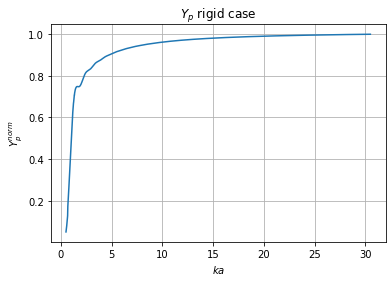

In [150]:
plt.ylabel('$Y_{p}^{norm}$')  
plt.xlabel('$ka$')

plt.plot(ka_array, Y_plane_array_rigid_norm)
# plt.scatter(f_array, Y_plane_array_norm)
grid1 = plt.grid(True)
plt.title('$Y_p$ rigid case')
plt.show()

Изобразим тот же график, но сузив диапазон аргумента до $ka = 10$, чтобы более детальней рассмотреть переломы.

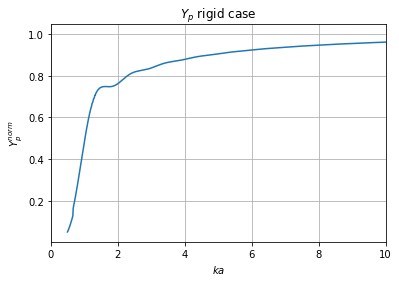

In [151]:
plt.ylabel('$Y_{p}^{norm}$')  
plt.xlabel('$ka$')

plt.plot(ka_array, Y_plane_array_rigid_norm)
# plt.scatter(f_array, Y_plane_array_norm)
grid1 = plt.grid(True)
plt.xlim(0,10)
plt.title('$Y_p$ rigid case')
plt.show()

При анализе графика по полученным кривым, видим, что радиационная сила быстро растет на низких частотах, однако после достижения некой критической точки (которая на самом деле является точкой, когда радиус рассеивателя (точнее ka, где а - радиус рассеивателя) становится порядка длины волны, рост замедляется и наступает насыщение, т.е. независимость силы от безразмерной частоты при дальнейшем увеличении последней величины.

<p>Для случая произвольного (не абсолютно жесткого рассеивателя) требуется учитывать упругие характеристики тела, поэтому введем вспомогательные функции.</p>

<p>В общем случае коэффициенты рассеянной волны находятся так:</p>
$$c_n = - \frac{F_n j_n(ka) - (ka)j_n^{'}(ka)}{F_n h_n^{(1)}(ka) - (ka)h^{(1)'}_n(ka)} \tag{1.7}$$
<p>где $F_n$:</p>
    $$F_n = \frac{\rho (k_t  a) ^ 2}{2  \rho_*} \frac{\alpha_n \delta_n + \beta_n \chi_n}{\alpha_n \eta_n + \beta_n \epsilon_n} \tag{1.8}
    $$

$$\rho_* - \text{ плотность}$$

$$\alpha_n = j_n(k_la) - (k_la)j_n^{'}(k_la)$$

$$\beta_n = (n^2 + n - 2)j_n(k_ta) + (k_ta)^2 j_n^{''}(k_ta)$$

$$\chi_n = (k_la)j_n^{'}(k_la)$$

$$\delta_n = 2n(n+1)j_n(k_ta)$$

$$\epsilon_n = (k_la)^2(j_n(k_la)\frac{\sigma}{1-2\sigma} - j_n^{''}(k_la))$$

$$\eta_n = 2n(n+1)(j_n(k_ta)-(k_ta)j_n^{'}(k_ta))$$

$$\sigma = \frac{c_l^2/2 - c_t^2}{c_l^2 - c_t^2}$$

$$k_{t,l} = \frac{\omega}{c_{t,l}} ~~\text{или}~~ k_{t,l}a = (ka) \frac{c_{t,l}}{c} \tag{1.9}$$

Обратим внимание на появление вторых производных сферических функций Бесселя.

<p>Вторая производная функции Бесселя находится из уравнения определяющие функции Бесселя через сами функции и их производные:</p>

$$\frac{d^2j_n(x)}{dx^2} = -\frac{2}{x}j_n^{'}(x) - (1 - \frac{n(n+1)}{x})j_n(x)$$

Определим функцию, возвращающую вторую производную сферической функции Бесселя, принимающая на вход саму сферическую функцию Бесселя, ее производную и аргумент (точку), в котором нам нужно рассчитать вторую производную.

In [130]:
def second_derivative(sphj, sphj_der, value, n):
    return  (-2) / value * sphj_der - (1 - n * (n + 1) / value ** 2) * sphj

Затем, согласно каждой величине в формуле $\text{(1.8)}$ и самой функции $\text{(1.8)}$, определим аналогичные функции программно.

In [131]:
def getSigma(c_l, c_t):
    return (c_l ** 2 / 2 - c_t ** 2) / (c_l ** 2 - c_t ** 2)

def alpha(n, ka_l, sphja_l, sphja_l_der):
    return sphja_l[n] - (ka_l) * sphja_l_der[n]

def beta(n, ka_t, sphja_t, sphja_t_der):
    return (n ** 2 + n - 2) * sphja_t[n] + (ka_t) ** 2 * second_derivative(sphja_t[n], sphja_t_der[n], ka_t, n)

def chi(n, ka_l, sphja_l_der):
    return (ka_l) * sphja_l_der[n]

def delta(n, sphja_t):
    return 2 * n * (n + 1) * sphja_t[n]

def eps(n, ka_l, sigma, sphja_l, sphja_l_der):
    return (ka_l) ** 2 * (sphja_l[n] * sigma / (1 - 2  * sigma) - second_derivative(sphja_l[n], sphja_l_der[n], ka_l, n))

def eta(n, ka_t, sphja_t, sphja_t_der):
    return 2 * n * (n + 1) * (sphja_t[n] - (ka_t * a) * sphja_t_der[n])

def F(n, ka_l, ka_t, rho_star, sigma, sphja_l, sphja_t, sphja_l_der, sphja_t_der):
    return (rho * (ka_t) ** 2) / (2 * rho_star) * (alpha(n, ka_l, sphja_l, sphja_l_der) * delta(n, sphja_t) + beta(n, ka_t, sphja_t, sphja_t_der) * chi(n, ka_l, sphja_l_der)) / (alpha(n, ka_l, sphja_l, sphja_l_der) * eta(n, ka_t, sphja_t, sphja_t_der) + beta(n, ka_t, sphja_t, sphja_t_der) * eps(n, ka_l, sigma, sphja_l, sphja_l_der))





Далее, согласно $\text{(1.6)}$ и $\text{(1.7)}$ построим функцию, аналогично той, которая вычисляла нам удельную радиационную силу в случае абсолютно жесткого рассеивателя, только здесь меняется условие на коэффициенты рассеянного поля.

Реализация:


1) для каждого $ka$ найдем $k_ta$, $k_la$ согласно $\text{(1.9)}$ необходимые для $c_n$.

2) $N_{max}$ определяем аналогично, либо $\text{upper_lim} * ka$, если эта величина больше либо равна единице, иначе $N_{max}=5$.

3) рассчитываем $j_n(ka),~y_n(ka),~j_n(k_la),~j_n(k_ta)$ и их первые производные.

4) пользуемся $\text{(1.7)}$ для нахождения $c_n$, затем, по найденным $c_n$ рассчитываем $Y_p(ka)$ в текущей точке $ka$ согласно $\text{(1.6)}$.

In [132]:
def getYp(c_l, c_t, rho_star, c_sound, ka_array, upper_lim, sigma):
    Y_plane = np.zeros(len(ka_array))
    
    for ind in range(len(ka_array)):
        ka_l = ka_array[ind] * c_sound / c_l
        ka_t  = ka_array[ind] * c_sound / c_t

        Nmax = trunc(upper_lim * ka_array[ind]) if trunc(upper_lim * ka_array[ind]) >= 1 else 5
        sphya_l, sphya_t = np.zeros(Nmax), np.zeros(Nmax)
        
        sphja, sphya = upperRecurency(ka_array[ind], Nmax)
        sphja_der, sphya_der = derivative(sphja, sphya, ka_array[ind])
        sphja_l = upperRecurency(ka_l, Nmax)[0]
        sphja_t = upperRecurency(ka_t, Nmax)[0]
        sphja_l_der = derivative(sphja_l, sphya_l, ka_l)[0]
        sphja_t_der = derivative(sphja_t,  sphya_t, ka_t)[0]
        
        c = np.zeros(Nmax + 1, dtype=complex)
    
        for n in range(Nmax + 1):
            ha = sphja[n] + 1j * sphya[n]
            ha_der = sphja_der[n] + 1j * sphya_der[n]
            c[n] = - (F(n, ka_l, ka_t, rho_star, sigma, sphja_l, sphja_t, sphja_l_der, sphja_t_der) * sphja[n] - (ka_array[ind] * sphja_der[n])) / ( F(n, ka_l, ka_t, rho_star, sigma, sphja_l, sphja_t, sphja_l_der, sphja_t_der) * ha - (ka_array[ind] * ha_der))

        for n in range(Nmax):
            Y_plane[ind] += (-4) * c_sound / ((ka_array[ind]) ** 2) * (n + 1) * np.real(c[n] + np.conj(c[n + 1]) + 2 * c[n] * np.conj(c[n + 1]))  
            
    return Y_plane

Рассмотрим результат реализованных функций. Положим $\rho = 1000~кг/м^3$, $c_{sound} = 1500~м/с$ (вода), в качестве верхнего предела суммирования возьмем число $3 = N_{max} / ka$. Упругие характеристики для стали и стекла, и плотности возьмем следующие:

$$c_l^{steel} = 5240~м/с$$

$$c_t^{steel} = 2978~м/с$$

$$\rho_*^{steel} = 7900~кг/м^3$$


$$c_l^{glass} = 5570~м/с$$

$$c_t^{glass} = 3430~м/с$$

$$\rho_*^{glass} = 2200~кг/м^3$$

In [133]:
rho = 1000
c_sound = 1500

c_l_steel = 5240 
c_t_steel = 2978
rho_star_steel = 7900

sigma_steel = getSigma(c_l_steel, c_t_steel)

Y_plane_array_steel_norm = norm(getYp(c_l_steel, c_t_steel, rho_star_steel, c_sound, ka_array, 3, sigma_steel))

c_l_glass = 5570 
c_t_glass = 3430
rho_star_glass = 2200
sigma_glass = getSigma(c_l_glass, c_t_glass)

Y_plane_array_glass_norm = norm(getYp(c_l_glass, c_t_glass, rho_star_glass, c_sound, ka_array, 3, sigma_glass))

Изобразим график для нормированной удельной радиационной силы в случае стального рассеивателя.

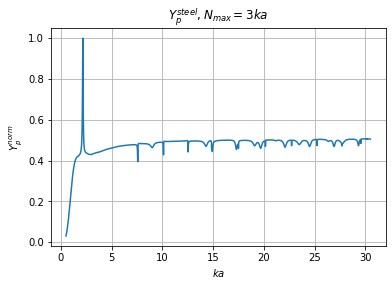

In [134]:
plt.ylabel('$Y_{p}^{norm}$')  
plt.xlabel('$ka$')

plt.plot(ka_array, Y_plane_array_steel_norm)
# plt.scatter(f_array, Y_plane_array_norm)
grid1 = plt.grid(True)
plt.title('$Y_p^{steel}, N_{max} = 3ka$')
plt.show()

Изобразим график для нормированной удельной радиационной силы в случае стеклянного рассеивателя

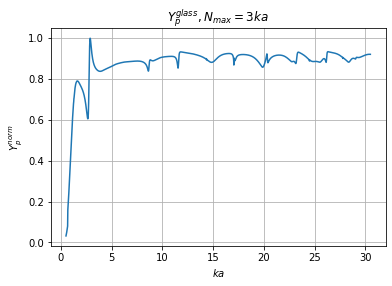

In [135]:
plt.ylabel('$Y_{p}^{norm}$')  
plt.xlabel('$ka$')

plt.plot(ka_array, Y_plane_array_glass_norm)
# plt.scatter(f_array, Y_plane_array_norm)
grid1 = plt.grid(True)
plt.title('$Y_p^{glass}, N_{max}=3ka$')
plt.show()

Как можем заметить, в отличие от абсолютно жесткого случая, для стали и стекла картинка иная. Здесь наблюдаются локальные провалы кривой, которые соответствуют резонансным колебаниям нашего рассеивателя на указанных безразмерных частотах.

Так же для удобства анализа можем изобразить все три полученные зависимости удельных радиационных сил на одном графике.

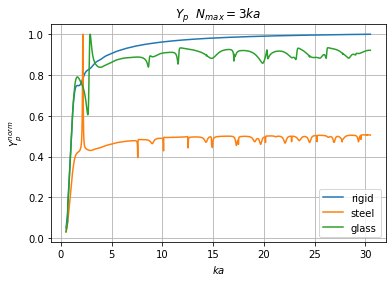

In [136]:
plt.ylabel('$Y_{p}^{norm}$')  
plt.xlabel('$ka$')

plt.plot(ka_array, Y_plane_array_rigid_norm, label='rigid')
plt.plot(ka_array, Y_plane_array_steel_norm, label='steel')
plt.plot(ka_array, Y_plane_array_glass_norm, label='glass')
# plt.scatter(f_array, Y_plane_array_norm)
grid1 = plt.grid(True)
plt.legend()
plt.title('$Y_p ~~N_{max}=3ka$')
plt.show()

<h3>Исследование сходимости рядов</h3>

Исследуем теперь вопрос сходимости наших рядов, в качестве метрики ошибки возьмем среднеквадратичное отклонение от удельной радиационной силы $Y_p$ предельного значения $Y_0$

$$SqrError(ka) = \sqrt{\int_{ka=\alpha}^{ka=\beta}{\frac{[Y_p(ka) - Y_0(ka)] ^ 2}{\beta - \alpha}}d(ka)}$$

Здесь предельным значением является удельная радиационная сила рассчитанная при количестве членов в сумме $5ka$, $\alpha = 0.5$, $\beta = 30$



Интеграл в пределе малых шагов по аргументу $ka$ заменим на сумму: 
$$\int_{ka=\alpha}^{ka=\beta}{\frac{[Y_p(ka) - Y_0(ka)] ^ 2}{\beta - \alpha}}d(ka) = \sum_{n=\alpha}^{\beta}{\frac{[Y_p(n\cdot ka) - Y_0(n\cdot ka)] ^ 2}{\beta - \alpha}}\delta n$$

Рассчитаем предельные значения удельных сил $Y_0$ в случаях абсолютно жесткого, стального и стеклянного рассеивателей

In [152]:
Y0_plane_array_rigid_norm = norm(getYpRigid(c_sound, ka_array, 5))
Y0_plane_array_steel_norm = norm(getYp(c_l_steel, c_t_steel, rho_star_steel, c_sound, ka_array, 5, sigma_steel))
Y0_plane_array_glass_norm = norm(getYp(c_l_glass, c_t_glass, rho_star_glass, c_sound, ka_array, 5, sigma_glass))

Введем вспомогательную функцию, в которую будем передавать рассчитанный массив функций $Y_p(ka)$ и предельных $Y_0$ в диапазоне изменения аргумента $ka$, а так же массив аргумента, для того, чтобы если у нас аргумент вдруг поменяется, чтобы ошибка считалась корректна (т.е. для корректного расчета длины пробегаемой оси аргумента).

In [138]:
def getError(Y, Y0, arg_list, arg_step):
    accumulator = 0
    for ind in range(len(Y)):
        accumulator += (Y[ind] - Y0[ind]) ** 2 * arg_step / (arg_list[len(arg_list) - 1] - arg_list[0])
    return accumulator ** .5

Теперь начнем изменять параметр для исследования сходимости рядов. Параметром здесь является верхний предел суммирования, точнее отношениее $N_{max}/{ka}$, будем его менять от 0.5 до 3 c шагом в 0.5.

Реализация:


1) при каждом $N_{max} / ka$ рассчитаем $Y_p$ при $ka$ изменяющимся от 0.5 до 30 с шагом в 0.01 удельные величины радиационных сил в случаях абсолютно жесткого, стального, стеклянного рассеивателей.

2) далее по имеющимся теперь значениям $Y_p(ka)$ и вычисленными раннее предельным значениям $Y_0(ka)$ рассчитаем среднеквадратичное отклонение в каждом аргументе при различных $N_{max}/ka$.

In [142]:
upper_lim_array = np.arange(0.5, 3.5, .5)
error_rigid, error_steel, error_glass = np.zeros(len(upper_lim_array)), np.zeros(len(upper_lim_array)), np.zeros(len(upper_lim_array))
for idx in range(len(upper_lim_array)):
    Y_plane_array_rigid_norm = norm(getYpRigid( c_sound, ka_array, upper_lim_array[idx]))
    Y_plane_array_steel_norm = norm(getYp(c_l_steel, c_t_steel, rho_star_steel, c_sound, ka_array, upper_lim_array[idx], sigma_steel))
    Y_plane_array_glass_norm = norm(getYp(c_l_glass, c_t_glass, rho_star_glass, c_sound, ka_array, upper_lim_array[idx], sigma_glass))
    error_rigid[idx] = getError(Y_plane_array_rigid_norm, Y0_plane_array_rigid_norm, ka_array, .01)
    error_steel[idx] = getError(Y_plane_array_steel_norm, Y0_plane_array_steel_norm, ka_array, .01)
    error_glass[idx] = getError(Y_plane_array_glass_norm, Y0_plane_array_glass_norm, ka_array, .01)

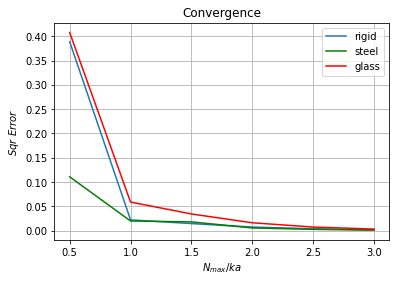

In [153]:
plt.ylabel('$Sqr~Error$')  
plt.xlabel('$N_{max}/ka$')

plt.plot(upper_lim_array, error_rigid, label='rigid')
plt.plot(upper_lim_array, error_steel, label='steel',  color='green')
plt.plot(upper_lim_array, error_glass, label='glass', color='red')
grid1 = plt.grid(True)

plt.legend()
plt.title(f'Convergence')
plt.show()

Получаем наглядную интерпретацию наших слов в формуле $\text{(1.4)}$: если взять $N_{max}/ka = 3$ ряды сходятся достаточно точно к своим предельным значениям.

Зададимся дополнительным вопросом об относительной ошибке для заданного $ka$. В качестве относительной ошибки возьмем следующую величину:
$$Relative~Error=|\frac{Y_p((ka)_{fixed}) - Y_0((ka)_{fixed})}{Y_0((ka)_{fixed})}| $$

In [154]:
def getRelativeError(Y, Y0):
    return abs((Y - Y0) / Y0)

Рассчитаем относительные ошибки для каждого фиксированного $ka$ в случаях абсолютно жесткого, стеклянного и стального рассеивателей.

In [156]:
relative_error_rigid, relative_error_steel, relative_error_glass = np.zeros(len(ka_array)), np.zeros(len(ka_array)), np.zeros(len(ka_array))
for ind in range(len(ka_array)):
    relative_error_rigid[ind] = getRelativeError(Y_plane_array_rigid_norm[ind], Y0_plane_array_rigid_norm[ind])
    relative_error_steel[ind] = getRelativeError(Y_plane_array_steel_norm[ind], Y0_plane_array_steel_norm[ind])
    relative_error_glass[ind] = getRelativeError(Y_plane_array_glass_norm[ind], Y0_plane_array_glass_norm[ind])

Изобразим полученные зависимости, обрезав интервал $ka$ до 2 (далее будет изображены все три графика на общем первоначальном масштабе значений $ka$ до 30), т.к. он неинформативен.

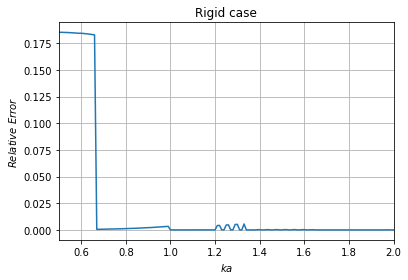

In [161]:
plt.ylabel('$Relative~Error$')  
plt.xlabel('$ka$')

plt.plot(ka_array, relative_error_rigid)
grid1 = plt.grid(True)

plt.title(f'Rigid case')
plt.xlim(0.5, 2)
plt.show()

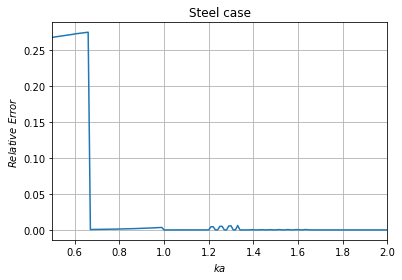

In [164]:
plt.ylabel('$Relative~Error$')  
plt.xlabel('$ka$')

plt.plot(ka_array, relative_error_steel)
grid1 = plt.grid(True)

plt.title(f'Steel case')
plt.xlim(0.5, 2)
plt.show()

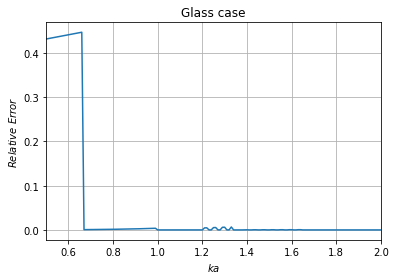

In [165]:
plt.ylabel('$Relative~Error$')  
plt.xlabel('$ka$')

plt.plot(ka_array, relative_error_glass)
grid1 = plt.grid(True)

plt.title(f'Glass case')
plt.xlim(0.5, 2)
plt.show()

На данном масштабе различий практически не видно, кроме первоначально больших ошибок, различных для разных рассеивателей (закономерных, т.к. Y0 мало). Попробуем посмотреть на более мелком масштабе оси ошибки.

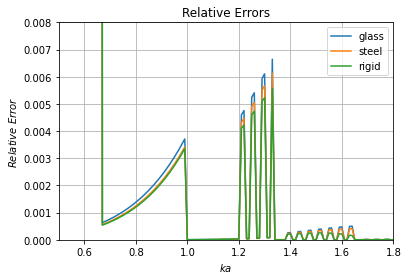

In [172]:
plt.ylabel('$Relative~Error$')  
plt.xlabel('$ka$')

plt.plot(ka_array, relative_error_glass, label='glass')
plt.plot(ka_array, relative_error_steel, label='steel')
plt.plot(ka_array, relative_error_rigid, label='rigid')

grid1 = plt.grid(True)

plt.title(f'Relative Errors')
plt.legend()
plt.xlim(0.5, 1.8)
plt.ylim(0, 0.008)
plt.show()

Видим, что изгибы кривых повторяются, различается лишь значение по модулю. Чем меньше относительная ошибка, тем ближе $Y_p$ к предельному удельному значений $Y_0$ в данной $ka$. Проанализируем полученную кривую: видно что на масштабе 1-1.2$ka$ ошибка практически нулевая, т.е. непосредственно вблизи рассеивателя все будет считаться достаточно точно. Далее, на масштабе 1.2-1.7$ka$ видим небольшую расходимость, связанную скорее всего с обрезанием ряда, т.к. ничем другим мы не принебрегали. Но и тут ошибка по модулю не превышает одну сотую, т.е. точность может отличаться максимум на 1% рассчитанных удельных величин радиационных сил.

Ну и полноценная картина всех трех зависимостей, не несущая информативности, кроме как малости ошибки при увеличении $ka$

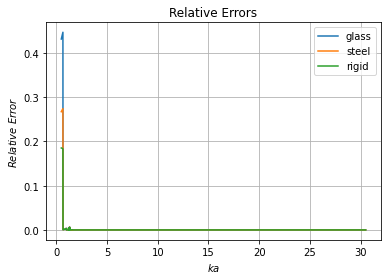

In [178]:
plt.ylabel('$Relative~Error$')  
plt.xlabel('$ka$')

plt.plot(ka_array, relative_error_glass, label='glass')
plt.plot(ka_array, relative_error_steel, label='steel')
plt.plot(ka_array, relative_error_rigid, label='rigid')

grid1 = plt.grid(True)

plt.title(f'Relative Errors')
plt.legend()
# plt.xlim(0.5, 30)
# plt.ylim(0, 0.004)
plt.show()

Так же зададимся еще раз вопросом об интегральной ошибке, взяв уже не абсолютное значение, а относительное:
$$Relative~Sqr~Error = \frac{\sqrt{\sum_{n = \alpha}^{\beta}[Y_p(n\cdot ka) - Y_0(n \cdot ka)] ^2 / N}}{\sum_{n=\alpha}^{\beta}Y_0(n\cdot ka)/N},~где~\alpha=0.5,~\beta=30,~N - \text{количество значений ka}$$

In [180]:
def getRelativeSqrError(Y_p, Y_0, ka_array):
    N = len(ka_array)
    upside_summ, downside_summ = 0, 0
    for ind in range(N):
        upside_summ += (Y_p[ind] - Y_0[ind]) ** 2 / N
        downside_summ += Y_0[ind] / N
        
    return (upside_summ) ** .5 / downside_summ

Рассчитаем относительные интегральные ошибки для случаев абсолютно жесткого, стального и стеклянного рассеивателей

In [181]:
relative_sqr_error_rigid, relative_sqr_error_steel, relative_sqr_error_glass = np.zeros(len(upper_lim_array)), np.zeros(len(upper_lim_array)), np.zeros(len(upper_lim_array))
for idx in range(len(upper_lim_array)):
    Y_plane_array_rigid_norm = norm(getYpRigid( c_sound, ka_array, upper_lim_array[idx]))
    Y_plane_array_steel_norm = norm(getYp(c_l_steel, c_t_steel, rho_star_steel, c_sound, ka_array, upper_lim_array[idx], sigma_steel))
    Y_plane_array_glass_norm = norm(getYp(c_l_glass, c_t_glass, rho_star_glass, c_sound, ka_array, upper_lim_array[idx], sigma_glass))
    relative_sqr_error_rigid[idx] = getRelativeSqrError(Y_plane_array_rigid_norm, Y0_plane_array_rigid_norm, ka_array)
    relative_sqr_error_steel[idx] = getRelativeSqrError(Y_plane_array_steel_norm, Y0_plane_array_steel_norm, ka_array)
    relative_sqr_error_glass[idx] = getRelativeSqrError(Y_plane_array_glass_norm, Y0_plane_array_glass_norm, ka_array)

Изобразим полученные кривые.

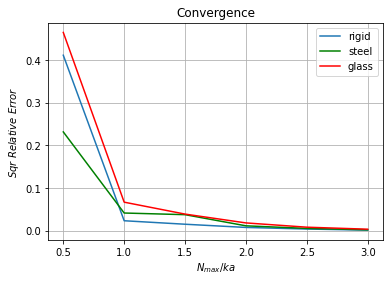

In [183]:
plt.ylabel('$Sqr~Relative~Error$')  
plt.xlabel('$N_{max}/ka$')

plt.plot(upper_lim_array, relative_sqr_error_rigid, label='rigid')
plt.plot(upper_lim_array, relative_sqr_error_steel, label='steel',  color='green')
plt.plot(upper_lim_array, relative_sqr_error_glass, label='glass', color='red')
grid1 = plt.grid(True)

plt.legend()
plt.title(f'Convergence')
plt.show()

Аналогично получаем, что ошибка стремится к нулю при стремлении отношения $N_{max}/ka$ к трем или выше. То есть обрезая сумму для порядков выше, чем 3ka, мы теряем незначительные величины.

Обратим  внимание, что идеализированный случай абсолютно жесткого рассеивателя вносит меньший вклад в относительную интегральную ошибку, то есть здесь расходимость результатов будет еще менее заметна.